# Классификация кошек и собак
---

### Загрузка библиотек

In [1]:
import os
import numpy as np
import random 
import matplotlib.pyplot as plt
import time
import glob

import torch
import torch.nn as nn
import torchvision
import torchvision.models as M
import torchvision.transforms.v2 as TV2
from torch.utils.data import Dataset, DataLoader
import cv2

%matplotlib inline

## Часть I. Предобученные сети как экстракторы признаков	

### Загрузка данных

In [2]:
train_path = "../input/dogs-vs-cats/train.zip"
test_path = "../input/dogs-vs-cats/test1.zip"

files = "/kaggle/working/"

import zipfile

with zipfile.ZipFile(train_path, 'r') as zipp:
    zipp.extractall(files)
    
with zipfile.ZipFile(test_path, 'r') as zipp:
    zipp.extractall(files)

In [3]:
train_path = '/kaggle/working/train/'
test_path = '/kaggle/working/test1'

# Получение списка файлов и директорий в указанной директории
train_content = os.listdir(train_path)
test_content = os.listdir(test_path)

print(f'Число изображений в треннировочной выборке: {len(train_content)}')
print(f'Число изображений в тестовой выборке:       {len(test_content)}')

Число изображений в треннировочной выборке: 25000
Число изображений в тестовой выборке:       12500


In [65]:
# Мы создаем класс CustomDataset и передаем аргумент Dataset, 
# чтобы он мог наследовать функционал класса Torch Dataset

class CustomDataset(Dataset):
    def __init__(self, train_flag='train', my_path=train_path, transform=None):
        self.imgs_path = my_path
        self.data = []
        self.transform = transform
        
        # Мы добавляем путь к файлу для каждого изображения в список 
        # self.data вместе с соответствующим именем класса. 
        for img_path in glob.glob(self.imgs_path + "/*.jpg"):
            class_name = img_path.split(".")[0].split("/")[-1]
            self.data.append([img_path, class_name])
        
        self.classes = ['dog', 'cat']
        self.class_map = {"dog" : 0, "cat": 1}
        self.img_dim = (224, 224)
        # Перемешаем данные
        random.shuffle(self.data) 
            
        # Разделим выборку на обучающую и валидационную
        if train_flag == 'train':
            self.data = self.data[:20000]
        elif train_flag == 'val':
            self.data = self.data[20000:]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        # Мы используем opencv, чтобы загрузить изображение и
        # изменить его размер до необходимого
        img = cv2.imread(img_path)
        img = cv2.resize(img, self.img_dim)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Словарь self.class_map обеспечивает отображение имени класса в метку.
        class_id = self.class_map[class_name]
        img_tensor = torch.from_numpy(img)
        img_tensor = img_tensor.permute(2, 0, 1)
        # Произведем скейлинг изображения: переведем пиксели от 0 до 255 к формату от 0 до 1 
        img_tensor = img_tensor / 255
        # Если задан трансформер, то правим изображение
        if self.transform:
            img_tensor = self.transform(img_tensor)

        class_id = torch.tensor([class_id])
        
        return img_tensor, class_id

Параметр **train_flag** класса CustomDataset позволяет нам выбирать между обучающей и тестовой выборкой.

In [5]:
train_data = CustomDataset()
val_data = CustomDataset('val')

BATCH_SIZE = 8

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)


Посмотрим на размер train_data с помощью метода __len__().

In [6]:
print('Train data len:', train_data.__len__())
print('Valid data len:', val_data.__len__())

Train data len: 20000
Valid data len: 5000


Отрисуем один батч картинок, загруженных с помощью DataLoader()

In [7]:
X_train, y_train = next(iter(train_loader))
img = torchvision.utils.make_grid(X_train)
img = img.numpy().transpose((1,2,0))

In [8]:
classes = train_data.classes
classes

['dog', 'cat']

['cat', 'cat', 'cat', 'dog', 'dog', 'cat', 'dog', 'dog']


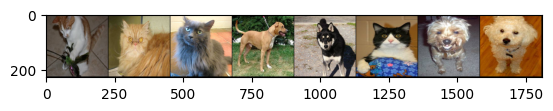

In [9]:
print([classes[i] for i in y_train])
plt.imshow(img);

### Загрузка модели

Мы будем использовать VGG16 в качестве предобученной сети.

In [11]:
model = M.vgg16(weights=M.VGG16_Weights.IMAGENET1K_V1)
print(model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 66.6MB/s] 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Это значит, что мы будем использовать уже обученные веса данной нейронной сети.

Веса можно получить в виде словаря "состояния" сети:

In [13]:
# model.state_dict()

In [12]:
total_params = sum(p.numel() for p in model.parameters())
print("Total parameters: ", total_params)

Total parameters:  138357544


### Заморозка слоев VGG16 сети

In [13]:
# Заморозка предполагает фиксацию весов модели во время обратного распространения ошибки 
for param in model.parameters():
    param.requires_grad = False

# Посмотрим, сколько нейронов подается на вход выходному слою классификатора
n_neurons = model.classifier[-1].in_features 
print(n_neurons)

# Заменим этот слой на новый, выходное количество нейронов которого
# соотвествует нашей задачи бинарной классификации
num_classes = 2
model.classifier[-1] = nn.Linear(n_neurons, num_classes)

4096


In [14]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=2, bias=True)
)

In [15]:
# Будем обучать только добавленный выходной слой классификатора
for index, param in enumerate(model.classifier.parameters()):
    if index == 6:
        param.requires_grad = True

In [16]:
use_gpu = torch.cuda.is_available()
print(use_gpu)

if use_gpu:
    device = 'cuda'
else:
    device = 'cpu'

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters())

True


In [17]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=2, bias=True)
)

### Обучение модели

Для удобства создадим словарь даталоадеров:

In [18]:
dataloaders = {
    'train': train_loader,
    'val': val_loader
}

In [19]:
def train_model(
    model, device, dataloaders, criterion,
    optimizer, batch_size, num_epochs=1, rep_freq=None):
    since = time.time()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # На каждой эпохе происходит обучение и валидая 
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() 
            else:
                model.eval() 
            
            current_loss = 0.0
            current_corrects = 0
            batch = 0

            # Проходим по данным
            for inputs, labels in dataloaders[phase]:
                batch += 1
                inputs = inputs.to(device)
                labels = labels.to(device)

                # обнуляем градиенты
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    # Получаем прогноз модели и считаем лосс
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    labels = labels.squeeze(-1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # считаем статистики
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels)
                
                # вывод отчета о динамике с указанной частотой
                if rep_freq:
                    if batch%rep_freq == 0 and phase == "train":
                        print("Batch {}, Train Loss:{:.4f}, Train ACC:{:.4f}".format(
                            batch, current_loss/(batch_size*batch),
                            100*current_corrects/(batch_size*batch)))

            epoch_loss = current_loss / CustomDataset(phase).__len__()
            epoch_acc = current_corrects.double() / CustomDataset(phase).__len__()

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
    time_elapsed = time.time() - since
    print('Время обучения: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    return model

In [20]:
cat_vs_dog = train_model(
    model, device, dataloaders, criterion,
    optimizer, batch_size=BATCH_SIZE,
    num_epochs=1, rep_freq=512
)

Epoch 0/0
----------
Batch 512, Train Loss:0.1484, Train ACC:94.2383
Batch 1024, Train Loss:0.1405, Train ACC:94.8486
Batch 1536, Train Loss:0.1601, Train ACC:94.5231
Batch 2048, Train Loss:0.1610, Train ACC:94.5984
train Loss: 0.1634 Acc: 0.9468
val Loss: 0.1019 Acc: 0.9658
Время обучения: 2m 21s


### Визуализация модели

In [21]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    _ = plt.figure()

    if use_gpu:
        device = 'cuda'
    else:
        device = 'cpu'

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(classes[preds[j]]))
                img = inputs.cpu().data[j]
                img = img.numpy().transpose((1, 2, 0))
                plt.imshow(img)

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

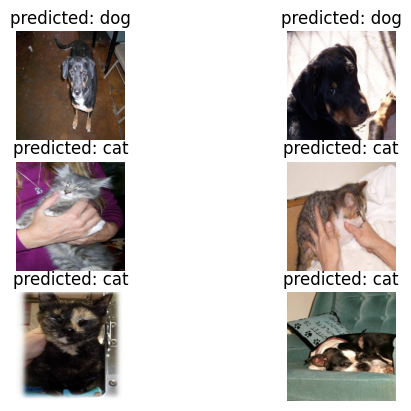

In [22]:
visualize_model(cat_vs_dog)
plt.show()

-----

## Часть II. Тонкая настройка модели

In [23]:
train_data_ft = CustomDataset()
val_data_ft = CustomDataset('val')

BATCH_SIZE = 16

train_loader_ft = DataLoader(
    train_data_ft, batch_size=BATCH_SIZE, shuffle=True
)
val_loader_ft = DataLoader(
    val_data_ft, batch_size=BATCH_SIZE, shuffle=True
)

Отрисуем один батч картинок, загруженных с помощью DataLoader()

In [24]:
def imshow(inp, title=None): 
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) 
    plt.figure(figsize=(15,10)) 
    plt.imshow(inp) 

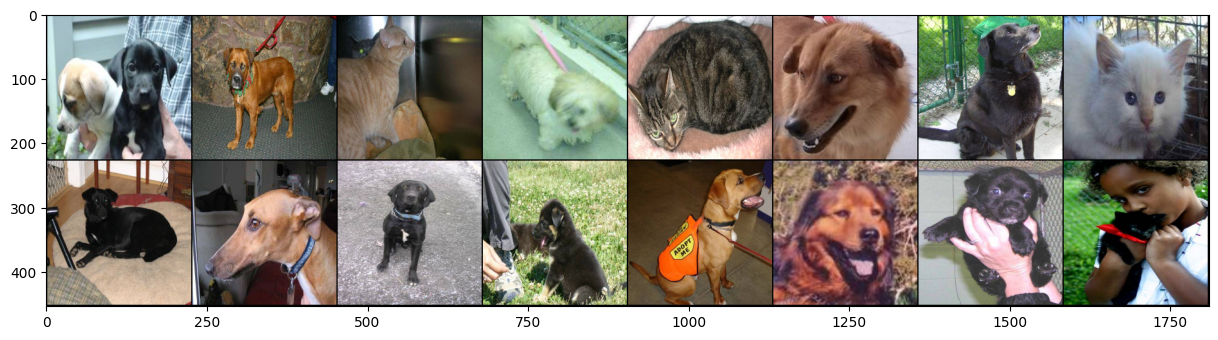

In [25]:
X_train_ft, y_train_ft = next(iter(train_loader_ft))
img = torchvision.utils.make_grid(X_train_ft, scale_each=True)
imshow(img)

Инициализируем модель

In [26]:
model = M.vgg16(weights=M.VGG16_Weights.IMAGENET1K_V1)

### Настройка слоев VGG16 сети

In [27]:
# Посмотрим, сколько нейронов подается на вход выходному слою классификатора
n_neurons = model.classifier[-1].in_features 
print(n_neurons)

# Заменим этот слой на новый, выходное количество нейронов которого
# соотвествует нашей задачи бинарной классификации
num_classes = 2
model.classifier[-1] = nn.Linear(n_neurons, num_classes)

4096


In [28]:
# Настроим 3 последних сверточных слоя сети
for index, param in enumerate(model.features.parameters()):
    if index >= 24:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [29]:
use_gpu = torch.cuda.is_available()
print(use_gpu)

if use_gpu:
      device = 'cuda'
else:
      device = 'cpu'

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

True


### Обучение модели

In [30]:
dataloaders_ft = {
    'train': train_loader_ft,
    'val': val_loader_ft
}

In [31]:
cat_vs_dog_finetuned = train_model(
    model, device, dataloaders_ft, criterion,
    optimizer, batch_size=BATCH_SIZE,
    num_epochs=1, rep_freq=512
)

Epoch 0/0
----------
Batch 512, Train Loss:0.3346, Train ACC:93.7256
Batch 1024, Train Loss:0.2985, Train ACC:94.3237
train Loss: 0.3008 Acc: 0.9433
val Loss: 0.2351 Acc: 0.9630
Время обучения: 2m 33s


### Визуализация модели

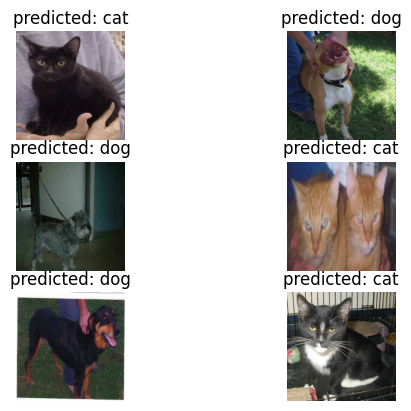

In [32]:
visualize_model(cat_vs_dog_finetuned)
plt.show()

## Часть III. Аугментация

Добавим аугментацию данных.

In [45]:
transformer = TV2.Compose([
    TV2.ToDtype(torch.uint8, scale=True),
    TV2.RandomHorizontalFlip(),
    TV2.ColorJitter(
        brightness=0.5, hue=0.3
    ),
#     TV2.RandomSolarize(threshold=210.0),
    TV2.ToDtype(torch.float32, scale=True),
#     TV2.Normalize(
#         mean=[0.485, 0.456, 0.406],
#         std=[0.229, 0.224, 0.225]
#     )
])

In [46]:
train_data_ft_aug = CustomDataset(transform=transformer)
val_data = CustomDataset('val')

BATCH_SIZE = 16

train_loader_ft_aug = DataLoader(
    train_data_ft_aug, batch_size=BATCH_SIZE, shuffle=True
)
val_loader = DataLoader(
    val_data, batch_size=BATCH_SIZE, shuffle=True
)

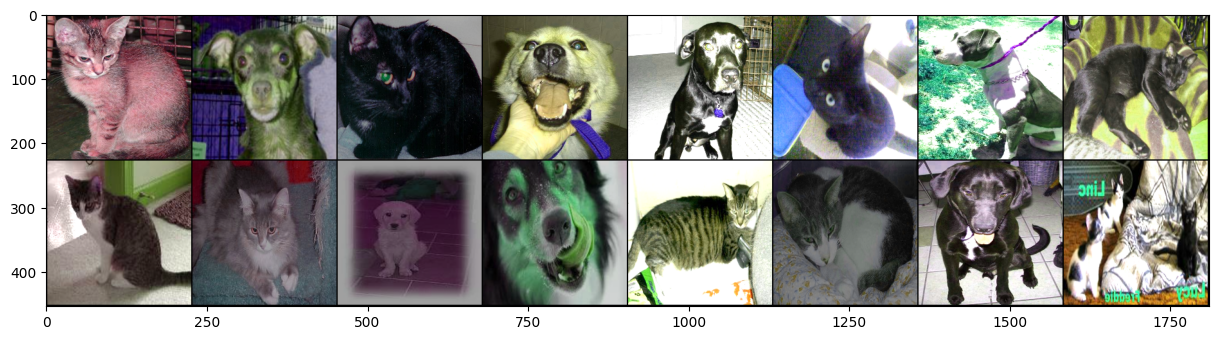

In [47]:
X_train_ft_aug, y_train_ft_aug = next(iter(train_loader_ft_aug))
img = torchvision.utils.make_grid(X_train_ft_aug, scale_each=True)
imshow(img)

In [48]:
model = M.vgg16(weights=M.VGG16_Weights.IMAGENET1K_V1)

n_neurons = model.classifier[-1].in_features 
print(n_neurons)

num_classes = 2
model.classifier[-1] = nn.Linear(n_neurons, num_classes)

for index, param in enumerate(model.features.parameters()):
    if index >= 24:
        param.requires_grad = True
    else:
        param.requires_grad = False
        
use_gpu = torch.cuda.is_available()
print(use_gpu)

if use_gpu:
      device = 'cuda'
else:
      device = 'cpu'

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

4096
True


In [49]:
dataloaders_ft_aug = {
    'train': train_loader_ft_aug,
    'val': val_loader
}

In [50]:
cat_vs_dog_finetuned_augmentation = train_model(
    model, device, dataloaders_ft_aug, criterion,
    optimizer, batch_size=BATCH_SIZE,
    num_epochs=1, rep_freq=512
)

Epoch 0/0
----------
Batch 512, Train Loss:0.2785, Train ACC:91.8945
Batch 1024, Train Loss:0.2691, Train ACC:92.2363
train Loss: 0.2611 Acc: 0.9245
val Loss: 0.1201 Acc: 0.9672
Время обучения: 4m 22s


Каким-то чудом точность на валидационной выборке чуток подросла: ранее различные комбинации аугментаций сказывались негативно, но это, видимо, мне еще не хватает пользовательского опыта.

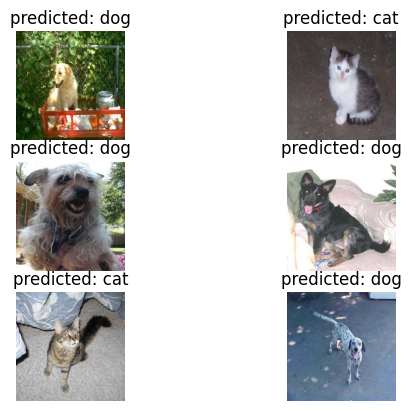

In [51]:
visualize_model(cat_vs_dog_finetuned_augmentation)
plt.show()

## Часть IV. Замена классификатора

Попробуем изменить модель путем полной замены полносвязного классификатора на новый.

In [52]:
train_data_new_clf = CustomDataset()
val_data_new_clf = CustomDataset('val')

BATCH_SIZE = 16

train_loader_new_clf = DataLoader(
    train_data_new_clf, batch_size=BATCH_SIZE, shuffle=True
)
val_loader_new_clf = DataLoader(
    val_data_new_clf, batch_size=BATCH_SIZE, shuffle=True
)

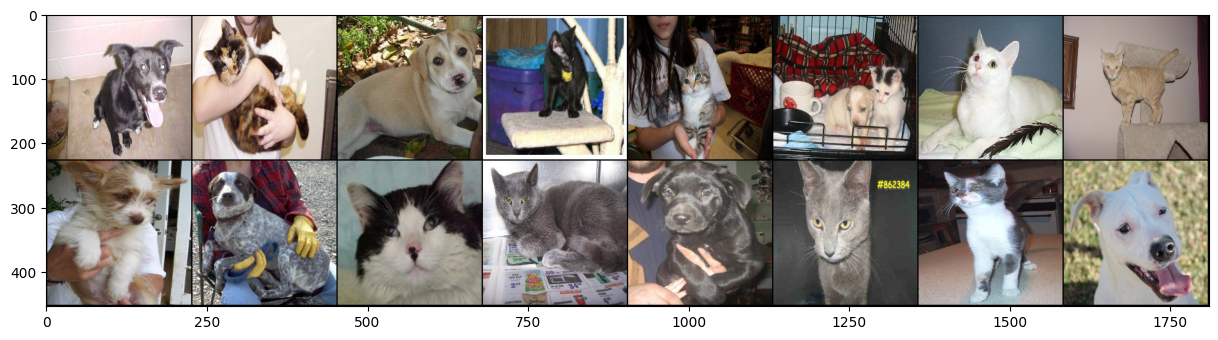

In [53]:
X_train_new_clf, y_train_new_clf = next(iter(train_loader_new_clf))
img = torchvision.utils.make_grid(X_train_new_clf, scale_each=True)
imshow(img)

In [54]:
model = M.vgg16(weights=M.VGG16_Weights.IMAGENET1K_V1)

model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [55]:
model.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(25088, 4096),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(4096),  # Добавим батч-нормализацию
    nn.Linear(4096, 1024),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(1024),  # Добавим батч-нормализацию
    nn.Linear(1024, out_features=2)
)

In [56]:
for index, param in enumerate(model.features.parameters()):
    if index >= 24:
        param.requires_grad = True
    else:
        param.requires_grad = False
        
use_gpu = torch.cuda.is_available()
print(use_gpu)

if use_gpu:
      device = 'cuda'
else:
      device = 'cpu'

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

True


In [57]:
dataloaders_new_clf = {
    'train': train_loader_new_clf,
    'val': val_loader_new_clf
}

In [58]:
cat_vs_dog_new_clf = train_model(
    model, device, dataloaders_new_clf, criterion,
    optimizer, batch_size=BATCH_SIZE,
    num_epochs=1, rep_freq=512
)

Epoch 0/0
----------
Batch 512, Train Loss:0.1710, Train ACC:93.5547
Batch 1024, Train Loss:0.1447, Train ACC:94.6228
train Loss: 0.1353 Acc: 0.9495
val Loss: 0.0513 Acc: 0.9822
Время обучения: 2m 29s


Похоже, дефолтный классификатор можно полностью подменить без ущерба для качества.

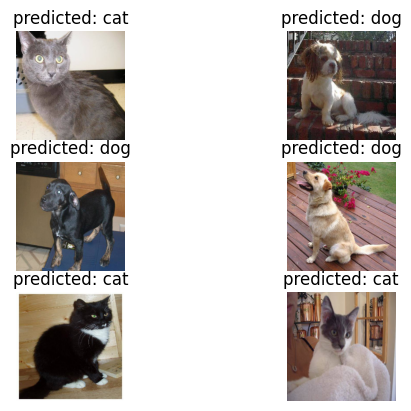

In [59]:
visualize_model(cat_vs_dog_new_clf)
plt.show()